# Imports

In [3]:
import numpy as np
import sympy as sp
from sympy import *
import re

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Style changes

In [4]:
rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Selfcoded functions

In [5]:
# mean value
def am(werte):
    return np.mean(werte)

# stdandard deviation
def std(werte):
    summen_der_quadrate = 0
    for wert in werte:
        summen_der_quadrate+=(wert-am(werte))**2       
    return np.sqrt(summen_der_quadrate/(werte.size-1))

# standard error
def stu(werte):
    return std(werte)/np.sqrt(werte.size)

# gaussian error propogation
def fehler(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += (dif * unsicherheiten[i])**2
    zMax = sqrt(zMax)
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

# maximum error with gaussian error propagation
def fehlerMax(f, werte, unsicherheiten, variablen):
    zMax = 0
    for i in range(werte.size):
        dif = np.abs(sy.diff(f, variablen[i]))
        zMax += dif * unsicherheiten[i]
    for j in range(werte.size):
        zMax = sub(zMax, variablen[j], werte[j])
    return zMax

# what error makes up the most of the resulting error in error propogation
def groessterBeitrag(f, werte, unsicherheiten, variablen):
    zMax = 0
    zMaxArray = np.array([])
    for i in range (werte.size):
        zMax = (np.abs(sy.diff(f, variablen[i])) * unsicherheiten[i])
        for j in range(werte.size):
            zMax = sub(zMax, variablen[j], werte[j])
        x = np.array([zMax])
        zMaxArray = np.append(zMaxArray, x)
    return variablen[np.argmax(zMaxArray)], zMaxArray[np.argmax(zMaxArray)]

# quality of life subsitution function for sympy tp substitute multiple variables at once
def sub(zMax, variable, wert):
    return zMax.subs([(variable, wert)])

# easier formula for gaussian error propagation with addition
def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

# easier formula for gaussian error propagation with multiplication
def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

# easier formula for maximum gaussian error propagation with multiplication
def einfachGaussMultMax(unsicherheiten, werte, exponenten):
    max_a = 0
    num = -1
    for i in range (unsicherheiten.size):
        maxi = (exponenten[i]*unsicherheiten[i]/werte[i])**2
        if max_a <= maxi:
            max_a = maxi
            num = i
    return (max_a, num)

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

# analytic linear regression y(x)=a + b*x calculates a
def bestA(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=a + b*x calculates b
def bestB(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, ehances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestA(x, y)+bestB(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=a + b*x calculates error on a
def stuA(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=a + b*x calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# Versuch Lichtlaufzeiten

Wichtige Anmerkungen zu den Codekonventionen:
- Variablennamen nutzen CamelCase und kürzen ab z.B.: linsenAbstandGegenstand was dem Abstand der Linse von der Gegenstandseite entspricht
- Fehler werden hierbei mit dem Suffix Err im CamelCase gekennzeichnet z.B.: abstandErr entspricht dem Fehler der Abstandsvariable 
- Einheiten stehen kommentiert nach den Einheiten z.B.: x = 3 # mm oder "vMax = 2 # V"


## Versuchsteil 1 - Chopper


In [6]:
# Funktion zur Berechnung der Brennweite
def brennweite(g, b):
    return 1/(1/g+1/b)


# Abstandsmessungen
abstandGegenstandLinse = 130 # mm
abstandLinseSchirm = 65      # mm

linsenAbstandGegenstand = 7      # mm
linsenAbstandSchirm = 3          # mm

# Fehler aller Abstandsmessungen
abstandErr = 1 # mm

# Berechnung der Brennweite
brennweite = brennweite(abstandGegenstandLinse+linsenAbstandGegenstand, abstandLinseSchirm+linsenAbstandSchirm)

# Berechnung des Fehlers der Brennweite mit Gausscher Fehlerforpflanzung
brennweiteErr = einfachGaussAdd(np.array([abstandErr,abstandErr]),np.array([1,1]))


md(f"Brennweite mit Fehler: ${brennweite:.1f} \pm {brennweiteErr:.1f}$ [mm]")

Brennweite mit Fehler: $45.4 \pm 1.4$ [mm]

### Erste Messreihe Chopper

In [7]:
# Gemessene Spannungen
spannungen = np.array([208, 197, 189, 179, 167, 155, 144, 135, 127, 117, 111, 104, 98, 93, 89, 85, 81, 
                       78, 74, 71, 69, 66, 64, 62, 59, 58, 53, 48, 46, 42, 40, 38, 37, 34, 33, 32, 30])  # mV

# Fehler der Spannungen (durch Variation am Oszilloskop geschätzt)
spannungenErr = 2 # mV

# Dazugehörige Frequenzen
frequenzenKlein = np.arange(150, 4050, 150)                    # Hz
frequenzenGroß = np.arange(4500, 10000, 500)                   # Hz
frequenzen = np.concatenate((frequenzenKlein, frequenzenGroß)) # Hz

# Fehler der Frequenzen
frequenzenErr = 20 # Hz

### Zweite Messreihe Chopper

50766


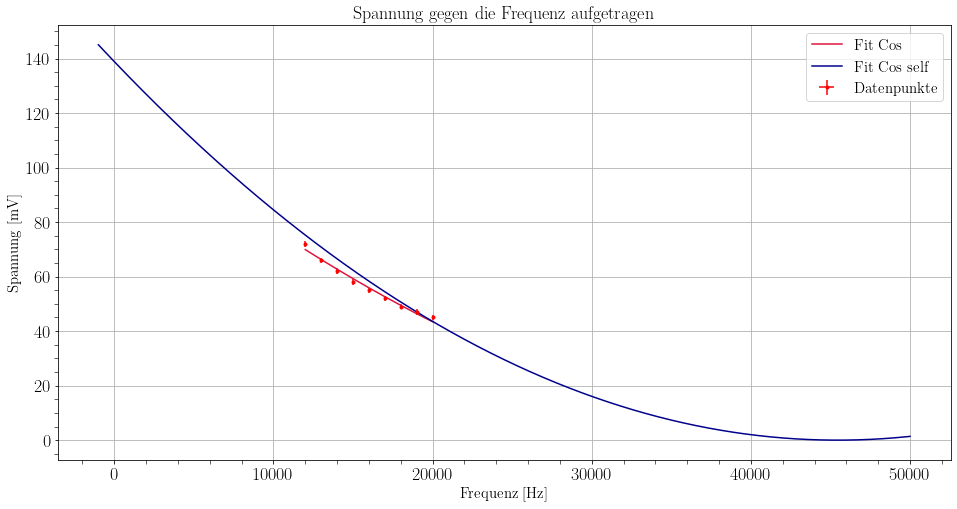

In [106]:
# Gemessene Spannungen
# spannungen2 = np.array([184, 161, 143, 129, 116, 108, 95, 72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV
spannungen2 = np.array([72, 66, 62, 58, 55, 52, 49, 47, 45])  # mV

# Fehler der Spannungen (durch Variation am Oszilloskop geschätzt)
#spannungen2Err = np.array([4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1])  # mV
spannungen2Err = 1 # mV

# Dazugehörige Frequenzen
frequenzen2 = np.arange(12, 21, 1)*1e3   # Hz

# Fehler der Frequenzen
frequenzen2Err = 20 # Hz

# Plotgröße anpassen
plt.figure(figsize=(16, 8))  

# FIt durch die Daten berechnen
xRange = np.arange(-1000, 50001, 1)

# Cosinusfunktion 
def myCos(x, f, p):
    return 3359420*np.cos(f*x+p) + 3359420

# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(x, *fit[0])
    print((myCos(xRange, *fit[0])).argmin())
    return data_fit

# Anfangswerte für den fit (geraten)
freqGuess = 2e-07
ampGuess = 3000000
phaseGuess = 3.1325
offsetGuess = 3000050
p0 = np.array([freqGuess, phaseGuess] )

# Berechnen der gefitteten Werte
fitWerte = fitCos(p0,frequenzen2,spannungen2)

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen2, spannungen2, xerr=frequenzen2Err, yerr=spannungen2Err, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzen2, fitWerte, color='crimson', label='Fit Cos',marker=None)

#plt.plot(xRange, myCos(xRange, 1/(320000*pc.pi), 3000000, pi/1.005, 3000050), color='darkblue', label='Fit Cos self',marker=None)

plt.plot(xRange, myCos(xRange, 2e-07, 3.1325), color='darkblue', label='Fit Cos self',marker=None)

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

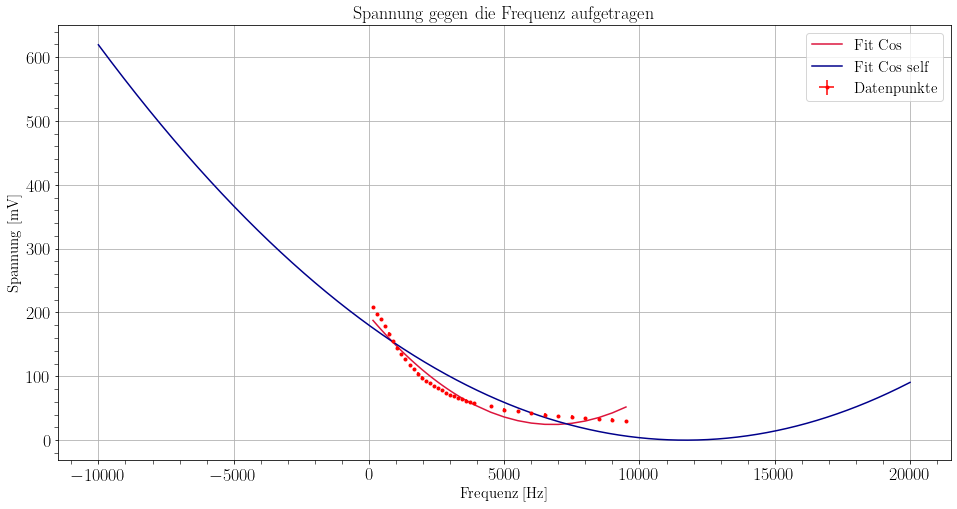

11704


In [11]:
# FIt durch die Daten berechnen

# Cosinusfunktion 
def myCos(x, f, a, p, o):
    return a*np.cos(f*x+p) + o

# Fitfunktion
def fitCos(p0, x, y):
    fit = curve_fit(myCos, x, y, p0=p0, maxfev = 10000000)
    data_fit = myCos(x, *fit[0])
    return data_fit

# Anfangswerte für den fit (geraten)
freqGuess = 1/(340000*pc.pi)
ampGuess = 3000000
phaseGuess = pi/1.0035
offsetGuess = 3000000
p0 = np.array([freqGuess, ampGuess, phaseGuess, offsetGuess] )
xRange = np.arange(-10000, 20001, 1)

# Berechnen der gefitteten Werte
fitWerte = fitCos(p0,frequenzen,spannungen)

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Gemessene Spannungswerte auftragen
plt.errorbar(frequenzen, spannungen, xerr=frequenzenErr, yerr=spannungenErr, 
             fmt='.', color='red', label='Datenpunkte', marker=None)

# Angepasste Cosinusfunktion aufzeichnen
plt.plot(frequenzen, fitWerte, color='crimson', label='Fit Cos',marker=None)

# Angepasste Cosinusfunktion auf größerem Bereich aufzeichnen
plt.plot(xRange, myCos(xRange, 1/(340000*pc.pi), 3000000, pi/1.0035, 3000000), color='darkblue', label='Fit Cos self',marker=None)

# labels und legend
plt.xlabel(r'Frequenz [Hz]')
plt.ylabel(r'Spannung [mV]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Frequenz aufgetragen')
plt.show()

# Minimum der Cosinusfunktion anzeigen lassen:

print(xRange[(myCos(xRange, 1/(340000*pc.pi), 3000000, pi/1.0035, 3000000)).argmin()])

## 2. Methode Funktionsgenerator
Die gesamte Strecke, welche das Licht zurücklegt wird entsprechend der Skizze mit der Formel

$$L = A + B + C + \sqrt{F^2+C^2}$$

bestimmt. Für den Fehler haben wir auf jede Messung einen Wert von $\Delta = 0.002$m geschätzt, bei diesem Werthandeölt es sich um einen statistischen Fehler, da er sich nicht nach der Skalenauflösung des Messinstruments richtet (das Messinstrument war ein Bandmaß mit einer Skalenauflösung von 1mm), sondern nach der Ungenauigkeit der vermessenden Person. Mittels der Gaußschen Fehlerfortpflanzung ergibt sich aus diesem Fehler dann ein Fehler für die gesamte Länge von 

$$\Delta L=\sqrt{0.006\text{m}+0.002\text{m}(F^{2}+C^{2})^{-\frac{1}{2}}(F+C)}$$

Der Fehler auf den Delay wurde mit $\Delta Delay = 0.2$ns geschätzt.

In [13]:
# Funktion zum Berechnen der Lichtlaufstrecke
def bestimmungLichtLaufstrecke(C):
    return np.sqrt(F**2+C**2) + A + B + C

# Funktion zum Berechnen des Fehlers auf die Lichtlaufstrecke mittels Gaußscher Fehlerfortpflanzung
def bestimmungLichtLaufstreckeErr(C): 
    return np.sqrt(0.006+0.002*(F**2+C**2)**(-1/2)*(F+C))

# Längen des Aufbaus:
A,B,F = 0.763, 0.750, 0.065                                 # m
MessungenC = np.array([0.74,0.64,0.54,0.44,0.34,0.24,0.14]) # m
StreckenmessungErr = 0.002                                  # m

# Gemessene Delays mit Average, min und max, abgelesen vom Oszilloskop
delayAverage = np.array([10.2,9.9,9.7,9.4,9,8.3,7.6]) * 10**-9 # s
delayMin = np.array([9.6,9.6,9.3,9.3,8.8,7.2,7.0]) * 10**-9    # s
delayMax = np.array([10.6,10.2,9.9,9.9,9.6,10.9,9.4]) * 10**-9 # s
delayErr = 0.2 * 10**-9                                        # s

# Berechnen Gesamt Länge und Fehler
LichtLaufstrecke2 = bestimmungLichtLaufstrecke(MessungenC)
LichtLaufstrecke2Err = bestimmungLichtLaufstreckeErr(MessungenC)

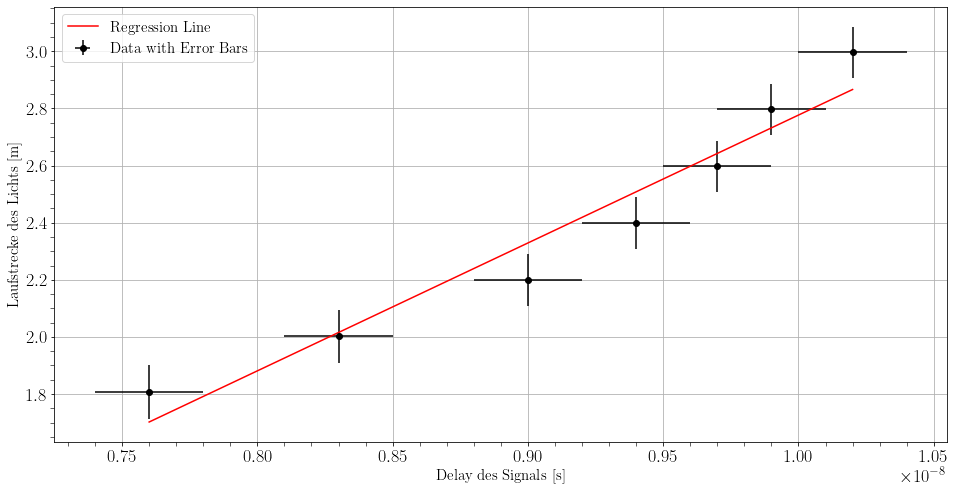

447730281.1860585


In [14]:
# Plotten der Daten und Lineare Regression
bTeil2 = bestA(delayAverage,LichtLaufstrecke2)
mTeil2 = bestB(delayAverage,LichtLaufstrecke2)

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Zeichnen der Datenpunkte in schwarz
plt.errorbar(delayAverage, LichtLaufstrecke2, yerr=LichtLaufstrecke2Err,
             xerr=delayErr, fmt='o', label='Data with Error Bars', color='black')

# Zeichnen der linearen Ausgleichsgerade in rot
plt.plot(delayAverage, mTeil2 * delayAverage + bTeil2, color='red', label='Regression Line')

# Achsenbeschriftungen
plt.xlabel(r'Delay des Signals [s]')
plt.ylabel(r'Laufstrecke des Lichts [m]')

plt.legend()
plt.show()

# Ausgabe der Steigung bzw. der Lichtgeschwindigkeit
print(mTeil2)

## 3. Pulslaser
Statt des einfachen Laserpointers wurde nun der Pulslaser angeschlossen, welcher mittels des Funktionsgenerator gesteuert wurde. 
Diesmal wurde nur der abstand D variiert. Es ergibt sich also für die Lichtlauflänge

$$L=A+B+C+D$$

Für den fehler ergibt sich 

$$\Delta L = \sqrt{4\cdot0.002\text{m}}=0.004\text{m}$$

In [15]:
# Daten eingeben

# Lichtlaufstrecke
A, B, C = 0.565, 0.782, 0.815
MessungenD = np.array([60,50,40,30,20,10])*0.01
fehlerStreckenmessung = 0.002

LichtLaufstrecke3 = MessungenD + A + B + C
LichtLaufstrecke3Err = np.sqrt(4*0.002)

#gemessene Delays mit Fehler
MessungDelay3 = np.array([12,11,10,9,7.6,5]) * 10**-9
MessungDelay3Err = np.array([1,1,1,1,0.5,2]) * 10**-9 

Ergebnis für die Lichtgeschwindigketit 72413793.10344855


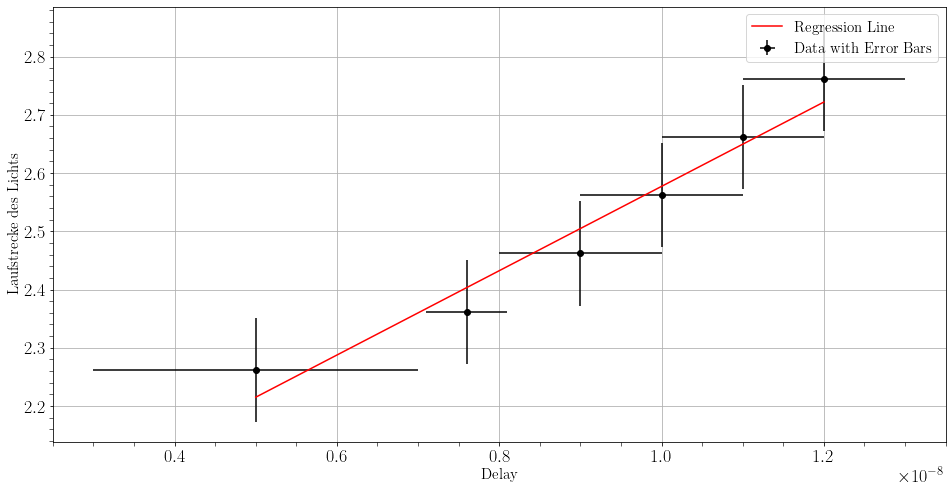

In [16]:
# Daten Plotten mit Errorbars

bTeil3 = bestA(MessungDelay3,LichtLaufstrecke3)
mTeil3 = bestB(MessungDelay3,LichtLaufstrecke3)

# Plotgröße anpassen
plt.figure(figsize=(16, 8))    

# Datenpunkte einzeichnen
plt.errorbar(MessungDelay3, LichtLaufstrecke3, yerr=LichtLaufstrecke3Err, xerr=MessungDelay3Err, 
             fmt='o', label='Data with Error Bars', color='black')

# Ausgleichsgerade einzeichnen
plt.plot(MessungDelay3, mTeil3 * MessungDelay3 + bTeil3, color='red', label='Regression Line')

#Ausgabe des Eregebnisses für die Lichtgeschwindigkeit
print("Ergebnis für die Lichtgeschwindigketit",mTeil3)

# Achsenbeschriftungen
plt.xlabel('Delay ')
plt.ylabel('Laufstrecke des Lichts')

plt.legend()
plt.show()